In [14]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
    LOCAL_DIR = './DATOS/'  # carpeta local en maquina virtual
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../FUENTES'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../DATOS/' # carpeta donde se encuentran los datasets
    LOCAL_DIR = DATOS_DIR

MODELOS_DIR = DATOS_DIR + '../MODELOS/'

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Define el codificador
El bloque decodificador utiliza capas convolucionales para extraer características.
Aplana las características y las pasa por una capa densa. Produce dos salidas: z_mean y z_log_var, que representan la media y el logaritmo de la varianza del espacio latente.

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from ipywidgets import interact
from matplotlib import pyplot as plt

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [16]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 14, 14, 32)           320       ['input_2[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d_2[0][0]']            
                                                                                                  
 flatten_1 (Flatten)         (None, 3136)                 0         ['conv2d_3[0][0]']            
                                                                                            

## Define funcion de muestreo
Utiliza z_mean y z_log_var para generar muestras del espacio latente e implementa una reparametrización para permitir el entrenamiento mediante retropropagación.

In [17]:
class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size, z_size = tf.shape(z_mean)[0], tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Define el bloque decodificador

El bloque decodificador toma muestras del espacio latente como entrada.
Utiliza capas densas y convolucionales transpuestas para reconstruir la imagen original.

In [18]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [19]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 1)         289 

## Define el paso de entrenamiento y las metricas utilizando una clase
El autonecoder variable combina el codificador, decodificador y muestreador.
Implementa la lógica de entrenamiento en el método train_step.
Calcula dos tipos de pérdidas:
a. Pérdida de reconstrucción: mide qué tan bien se reconstruye la imagen original.
b. Pérdida KL: mide la divergencia entre la distribución latente y una distribución normal estándar.

In [20]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")


    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]


    def train_step(self, data):

        with tf.GradientTape() as tape: # GradientTape para registrar las operaciones para la diferenciación automática

            z_mean, z_log_var = self.encoder(data) # Codifica entrada y obtiene media y log-varianza del espacio latente

            z = self.sampler(z_mean, z_log_var)    # Muestrea del espacio latente usando reparametrización

            reconstruction = decoder(z)            # Reconstruye la entrada usando el decoder

            # Calcula la pérdida de reconstrucción (binary crossentropy)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)) # Calcula Kullback-Leibler divergence
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss) # Combina y obtiene pérdida total

        grads = tape.gradient(total_loss, self.trainable_weights)  # Calcula los gradientes

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))  # Aplica gradientes para actualizar los pesos

        # Actualiza las métricas de pérdida
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        # Retorna diccionario con los valores de las métricas
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## Entrenar el modelo con MNIST

In [21]:
import numpy as np

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae_model = VAE(encoder, decoder)
vae_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005))
vae_model.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 11s 11ms/step - total_loss: 212.8234 - reconstruction_loss: 212.7385 - kl_loss: 0.0849
Epoch 2/30
547/547 [==============================] - 5s 8ms/step - total_loss: 199.1092 - reconstruction_loss: 198.1683 - kl_loss: 0.9403
Epoch 3/30
547/547 [==============================] - 4s 8ms/step - total_loss: 164.0613 - reconstruction_loss: 160.9312 - kl_loss: 3.1300
Epoch 4/30
547/547 [==============================] - 6s 10ms/step - total_loss: 158.0464 - reconstruction_loss: 154.6810 - kl_loss: 3.3654
Epoch 5/30
547/547 [==============================] - 5s 9ms/step - total_loss: 155.5698 - reconstruction_loss: 152.1007 - kl_loss: 3.4692
Epoch 6/30
547/547 [==============================] - 4s 8ms/step - total_loss: 154.2091 - reconstruction_loss: 150.6784 - kl_loss: 3.5307
Epoch 7/30
547/547 [==============================] - 5s 9ms/step - total_loss: 153.1765 - reconstruction_loss: 149.6214 - kl_loss: 3.5551
Epoch 8/30
547/547 [====

### Guarda codificador y decodificador para recrear el VAE sin entrenarlo

In [22]:
vae_model.encoder.save(MODELOS_DIR + 'VAE_MNIST_encoder.h5')
vae_model.decoder.save(MODELOS_DIR + 'VAE_MNIST_decoder.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Recupera codificador y decodificador para recrear el modelo VAE

In [23]:
encoder = keras.models.load_model(MODELOS_DIR + 'VAE_MNIST_encoder.h5')
decoder = keras.models.load_model(MODELOS_DIR + 'VAE_MNIST_decoder.h5')

vae_model = VAE(encoder, decoder)

## Muestra la grilla de imágenes generadas a partir del espacio latente


Generando gráficos


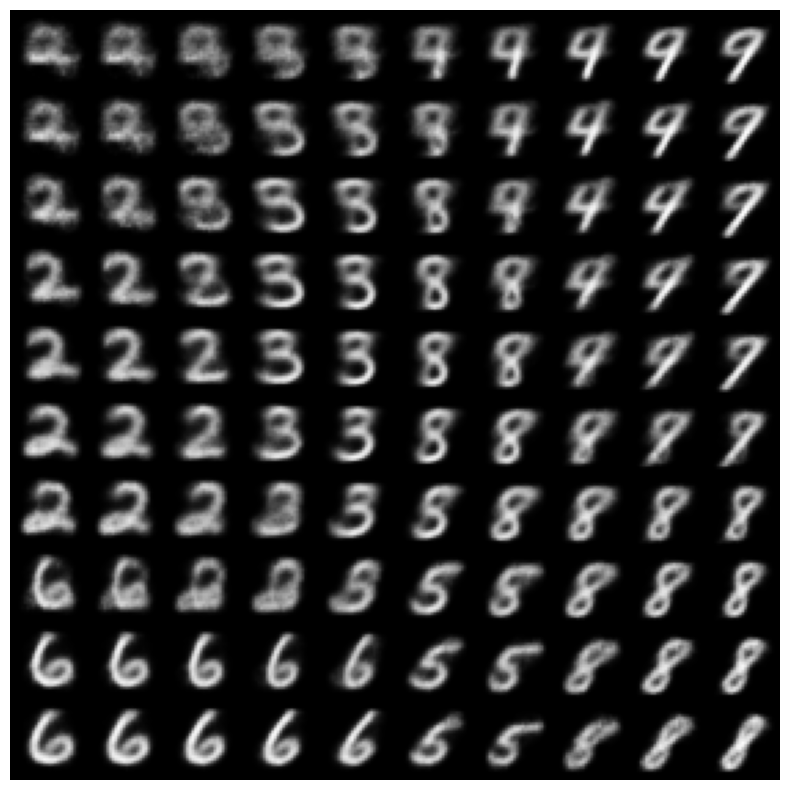

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def dibujar_espacio_latente(vae, n=30, latent_dim=2):
    digit_size = 28  # Tamaño de cada dígito
    scale = 1        # Escala para el espacio latente
    figure = np.zeros((digit_size * n, digit_size * n))  # matriz para almacenar las imágenes generadas

    # Puntos en el espacio latente a lo largo de los ejes X e Y
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]  # Invierte para una visualización más intuitiva

    # Iterar sobre los puntos en el espacio latente
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])  # Generar una muestra en el espacio latente
            x_decoded = vae.decoder.predict(z_sample, verbose=0)  # Decodificar la muestra para generar una imagen
            digit = x_decoded[0].squeeze()  # Eliminar la dimensión extra y obtener una matriz 2D
            # Reorganizar la imagen generada al tamaño del dígito y almacenarla en la matriz
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    # Muestra matriz de imágenes generadas
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap=plt.cm.gray)  # Mostrar la matriz como una imagen
    plt.axis("off")  # Ocultar ejes y etiquetas
    plt.show()

print("Generando gráficos")
dibujar_espacio_latente(vae_model, n=10, latent_dim=2)

# Visualización interactiva del espacio latente

interactive(children=(IntSlider(value=0, description='x', min=-100), IntSlider(value=0, description='y', min=-…

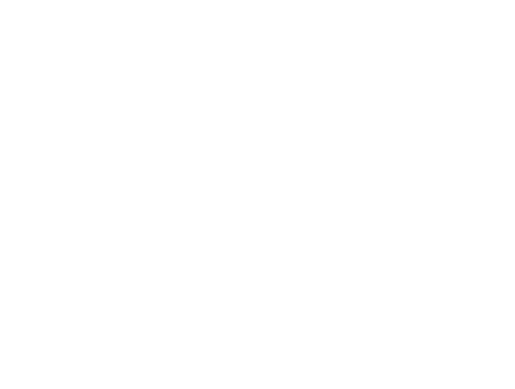

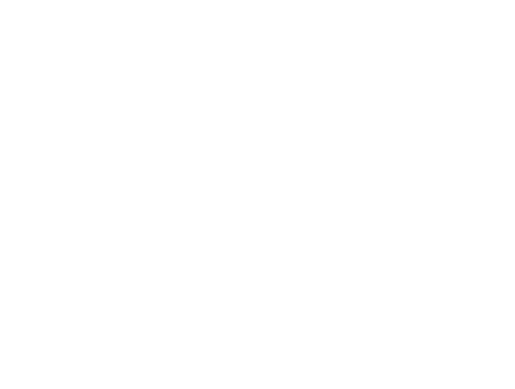

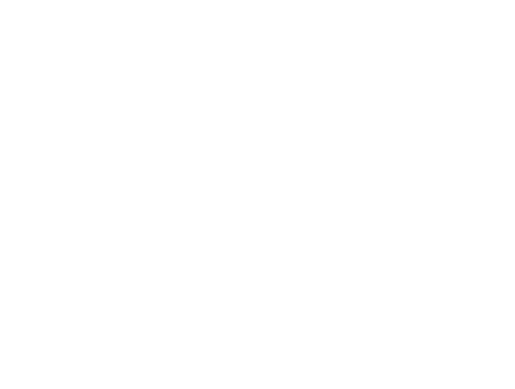

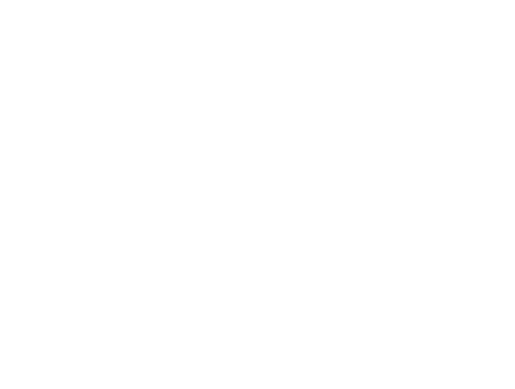

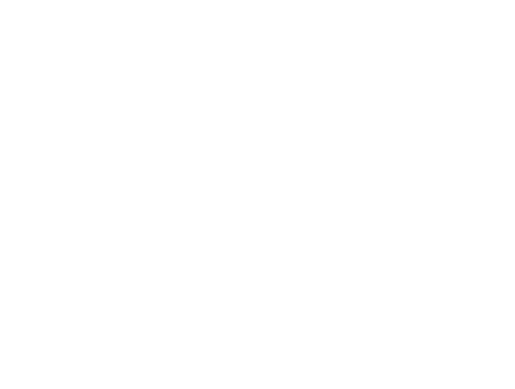

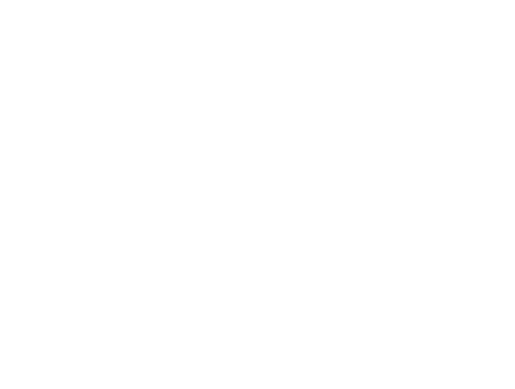

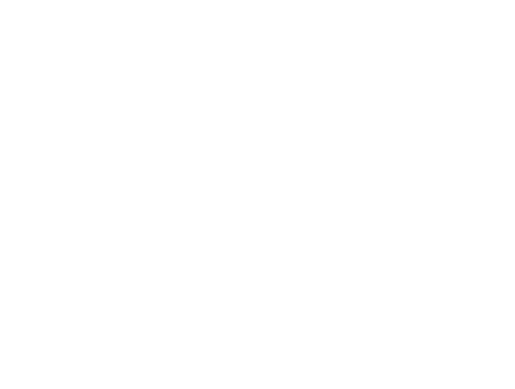

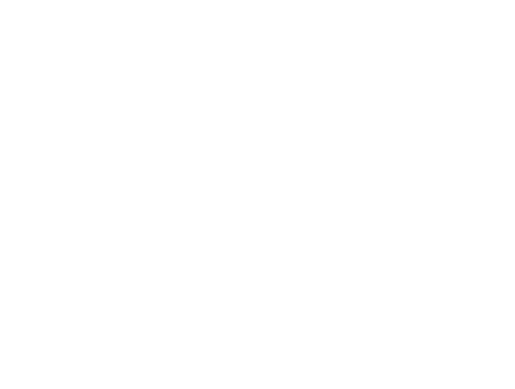

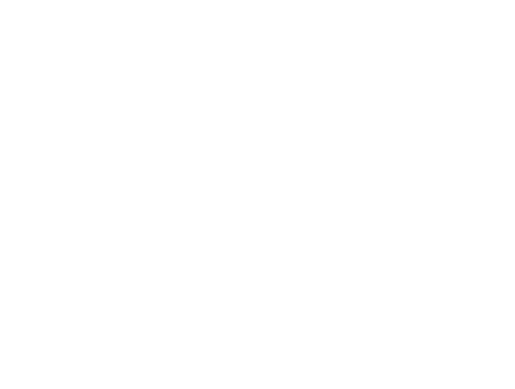

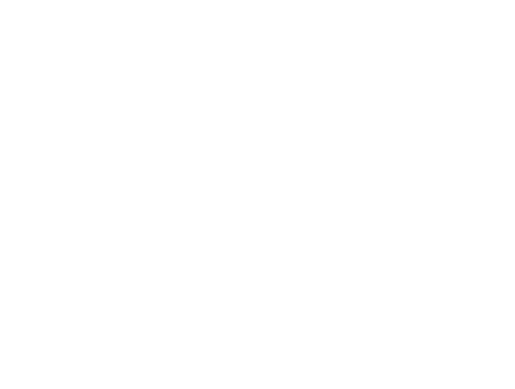

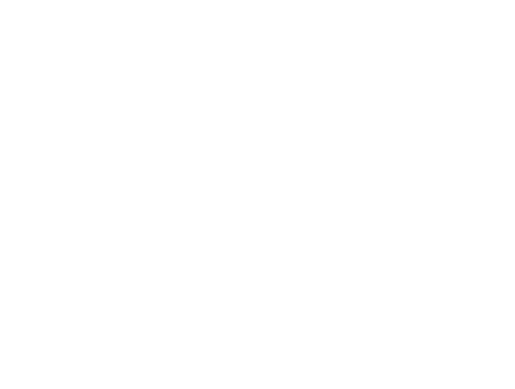

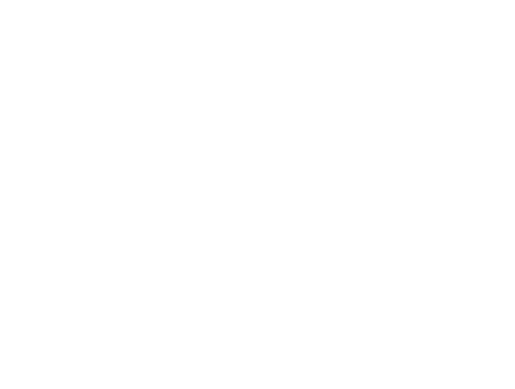

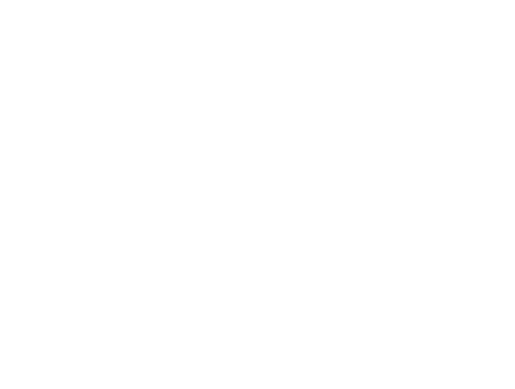

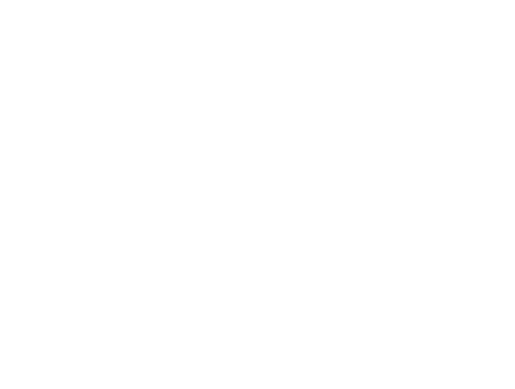

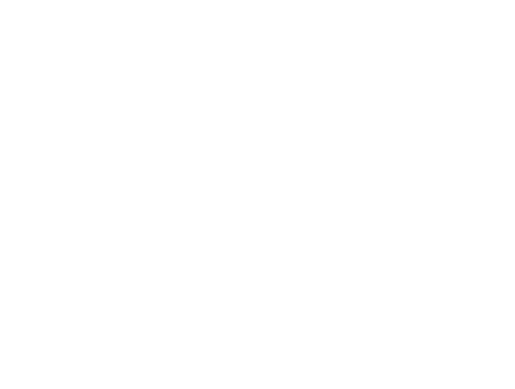

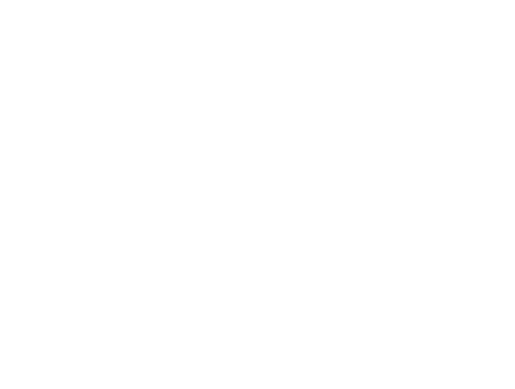

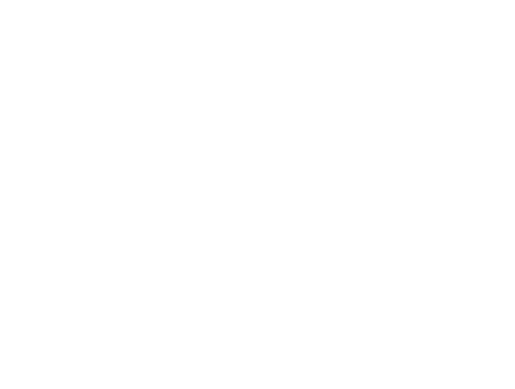

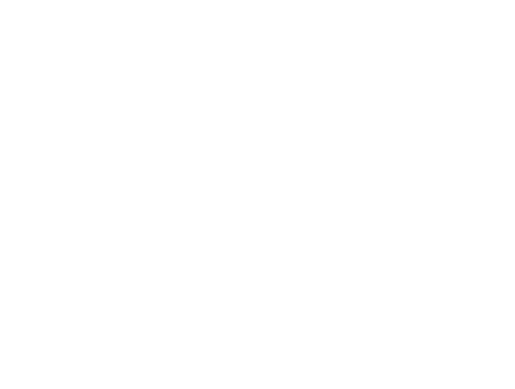

In [25]:
from ipywidgets import interact


def dibujar_digito_espacio_latente(vae, n=30, figsize=15):

    # Función para generar una imagen en función de coordenadas (xi, yi)
    def gen_img(xi, yi):
        digit_size = 28

        z_sample = np.array([[xi, yi]]) # Genera una muestra en el espacio latente

        # Decodificar la muestra para generar una imagen
        x_decoded = vae.decoder.predict(z_sample, verbose=0)

        return x_decoded[0]

    ESCALA = 100 # Escala barra de control

    # Función que muestra digito generado al interacturar con las barras
    def mostrar_imagen(x, y):
        # Invirtiendo 'y' para coincidir con la orientación gráfica
        plt.figure(figsize=(3,3))
        plt.imshow(gen_img(x/ESCALA, -y/ESCALA), cmap=plt.cm.coolwarm, interpolation='nearest')
        plt.show()  # Mostrar la imagen generada
        plt.axis("off")  # Ocultar ejes y etiquetas

    interact(mostrar_imagen, x=(-ESCALA, ESCALA), y=(-ESCALA, ESCALA))

dibujar_digito_espacio_latente(vae_model)